In [1]:
import platform

print(platform.machine())

arm64


In [13]:
import io
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import pathlib

import time
from selenium import webdriver
from PIL import Image
from matplotlib import pyplot as plt

In [38]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
device = torch.device("cpu")

class ImageDataset(Dataset):
    def __init__(self, labels, data, transform=None, target_transform=None):
        self.img_labels = torch.from_numpy(labels)
        self.img_labels = self.img_labels.to(device)
        
        data = np.moveaxis(data, 3, 1)
        print(data.shape)
        self.img_data = torch.from_numpy(data)
        print(self.img_data.shape)
        self.img_data = self.img_data.to(device)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_data[idx]
        
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

200
(400, 3, 224, 224)
torch.Size([400, 3, 224, 224])
(224, 224, 3)


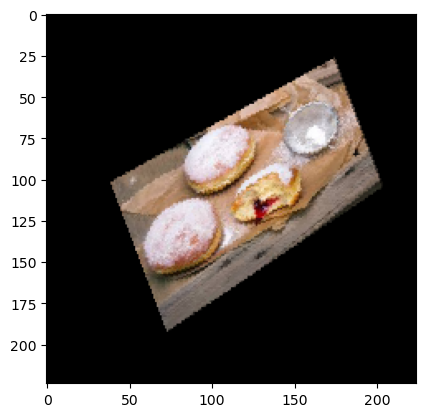

In [47]:
X_train = list()
y_train = list()
for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        
        X_train.append(pix)
        y_train.append(0)

        
print(len(X_train))
length = len(X_train)

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        X_train.append(pix)
        y_train.append(1)
    if len(X_train) > length*2:
        break
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)



trainset = ImageDataset(y_train, X_train, transform=transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.RandomRotation(degrees=(0, 180))
]))

"""
data, lbl = trainset.__getitem__(0)
data = np.asarray(data)
data = np.moveaxis(data, 0, 2)
print(data.shape)

plt.imshow(data) 
plt.show()
""";

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 3, stride=1, padding=1) # 224x224x9
        self.pool1 = nn.MaxPool2d(2, 2) # 224x224x9 -> 112x112x9
        self.conv2 = nn.Conv2d(9, 27, 3, stride=1, padding=1) # 112x112x27
        self.pool2 = nn.MaxPool2d(2, 2) # 112x112x27 -> 56x56x27
        self.conv3 = nn.Conv2d(27, 54, 3, stride=1, padding=1) # 56x56x54
        self.pool3 = nn.MaxPool2d(2, 2) # 56x56x54 -> 28x28x54
        self.fc1 = nn.Linear(28*28*54, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x


convnet = ConvNet()
convnet

net = ConvNet()
net.to(device=device)

ConvNet(
  (conv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(27, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=42336, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)

In [5]:
def performance_on_dev_set(net, devset, criterion):
  dev_dataloader = torch.utils.data.DataLoader(devset, batch_size=25, num_workers=0, shuffle=True)
  correct = 0
  total = 0
  with torch.no_grad():
      dev_loss = 0.0
      for data in dev_dataloader:
          images, labels = data

          # calculate outputs by running images through the network
          outputs = net(images)
          loss = criterion(outputs, labels)
          dev_loss += loss
          # the class with the highest value is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          labels = [torch.max(elem) for elem in labels]
          total += len(labels)
          
          for i in range(len(labels)):
            if predicted[i] == labels[i]:
              correct += 1

  accuracy = correct / total
  avg_dev_loss = dev_loss / len(dev_dataloader)
  return accuracy, avg_dev_loss


In [7]:
from tqdm import tqdm
import torch.optim as optim

# Fix random seed to get reproducibility
torch.manual_seed(42)

batch_size=10
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.003)
losses = []
dev_losses = []
dev_accuracys = []
for epoch in range(1000):  # loop over the dataset multiple times
    if epoch % 100 == 0: # epoch = 100 epochs due to data augmentation
        print(f"------ Epoch {epoch//100+1} ------")
    running_loss = 0.0

    # EXTRA: get a nice progress bar visualization
    train_progress  = tqdm(train_dataloader, desc=f"Epoch {epoch//100 + 1}", mininterval=0.3)
    for i, data in enumerate(train_progress, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())
        train_progress.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.3}")

print('Finished Training')
plt.plot(losses, label='train loss')
plt.legend()



------ Epoch 1 ------


Epoch: 100, loss: 0.693: 100%|██████████| 72/72 [00:12<00:00,  5.63it/s]


------ Epoch 2 ------


Epoch: 200, loss: 0.693: 100%|██████████| 72/72 [00:13<00:00,  5.28it/s]


------ Epoch 3 ------


Epoch: 300, loss: 0.694: 100%|██████████| 72/72 [00:12<00:00,  5.57it/s]


------ Epoch 4 ------


Epoch: 400, loss: 0.693: 100%|██████████| 72/72 [00:12<00:00,  5.70it/s]


------ Epoch 5 ------


Epoch: 500, loss: 0.693: 100%|██████████| 72/72 [00:12<00:00,  5.55it/s]


------ Epoch 6 ------


Epoch: 600, loss: 0.694: 100%|██████████| 72/72 [00:12<00:00,  5.63it/s]


------ Epoch 7 ------


Epoch: 700, loss: 0.694: 100%|██████████| 72/72 [00:12<00:00,  5.63it/s]


------ Epoch 8 ------


Epoch: 800, loss: 0.693: 100%|██████████| 72/72 [00:12<00:00,  5.55it/s]


------ Epoch 9 ------


Epoch: 853, loss: 0.691:  69%|██████▉   | 50/72 [00:09<00:03,  5.62it/s]

: 

: 

In [50]:
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/8e670e4afba12afb3a87c4b11598e6e11d1380a7.bmp"
test_pic = Image.open(test_path)
test_data = np.asarray(test_pic)
test_data = (test_data / 255.0)
test_data = test_data.astype(np.float32)
test_data = test_data.reshape(-1, 3 , 224, 224)
test_data = torch.from_numpy(test_data)

prediction = net(test_data)
prediction_loss = criterion(prediction, torch.tensor([0]))
prediction_loss
prediction

tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward0>)

In [9]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

X_train = X_train.reshape(-1, 3 * 224 * 224)

model = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', verbose=1)
model.fit(X_train, y_train)

[LibLinear]iter  1 act 4.245e+02 pre 3.701e+02 delta 1.130e+00 f 5.587e+02 |g| 3.642e+03 CG  21
iter  2 act 8.753e+01 pre 7.051e+01 delta 1.130e+00 f 1.342e+02 |g| 9.222e+02 CG  22
iter  3 act 2.687e+01 pre 2.143e+01 delta 1.130e+00 f 4.667e+01 |g| 3.378e+02 CG  21
iter  4 act 8.702e+00 pre 6.988e+00 delta 1.130e+00 f 1.980e+01 |g| 1.259e+02 CG  19
iter  5 act 2.508e+00 pre 2.063e+00 delta 1.130e+00 f 1.110e+01 |g| 4.702e+01 CG  19
iter  6 act 5.144e-01 pre 4.367e-01 delta 1.130e+00 f 8.593e+00 |g| 1.683e+01 CG  18
iter  7 act 8.749e-02 pre 7.559e-02 delta 1.130e+00 f 8.078e+00 |g| 5.479e+00 CG  19
iter  8 act 2.858e-02 pre 2.552e-02 delta 1.130e+00 f 7.991e+00 |g| 1.698e+00 CG  31
iter  9 act 2.565e-03 pre 2.448e-03 delta 1.130e+00 f 7.962e+00 |g| 5.643e-01 CG  32


LogisticRegression(multi_class='ovr', solver='liblinear', verbose=1)

Actual value from test data is 0 and corresponding image is as below


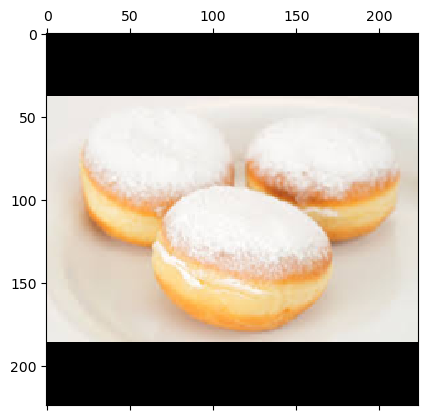

Predicted value from test data is 0 and corresponding image is as below


In [15]:
test_path1 = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/8e670e4afba12afb3a87c4b11598e6e11d1380a7.bmp"
test_path2 = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/9437b83fef0055de0eff16416d5d5885eaed8f09.bmp"
test_pic = Image.open(test_path2)
test_data = np.asarray(test_pic)
test_data = (test_data / 255.0)
test_data = test_data.astype(np.float32)
test_data = test_data.reshape(-1, 3 , 224, 224)
test_data = torch.from_numpy(test_data)
test_data = test_data.reshape(-1, 3 * 224 * 224)

pred = model.predict(test_data)
pred

print(f'Actual value from test data is 0 and corresponding image is as below')
plt.matshow(test_data.reshape((224,224,3))) 
plt.show()
print(f'Predicted value from test data is {pred[0]} and corresponding image is as below')

